<a href="https://colab.research.google.com/github/pulindu-seniya-silva/Fake-News-Detection-NLP/blob/fix-overfitting/Fake_News_detection_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
#installing NLTK for text preprocessing
!pip install nltk


In [64]:
 #install Hugging Face 'transformers' library for BERT/deep Learning
!pip install transformers

# Loading the dataset

In [65]:

#Data Manipulation and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Load both files
# Added engine='python' to handle potential parsing issues with CSV files
df_fake = pd.read_csv('Fake.csv', engine='python', encoding='utf-8', on_bad_lines='skip')
df_true = pd.read_csv('True.csv', engine='python', encoding='utf-8', on_bad_lines='skip')

# 2. Assign labels manually (since the files don't have a 'label' column)
df_fake['label'] = 1  # 1 for Fake
df_true['label'] = 0  # 0 for Real

# 3. Combine them into one big dataframe
df = pd.concat([df_fake, df_true], axis=0).reset_index(drop=True)

# 4. Shuffle the data (Very Important!)
# If you don't shuffle, the model sees all Fake news first and then all Real news,
# which confuses the training process.
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)

print(f"Total rows: {len(df)}")
print(df['label'].value_counts())
df.head()

Total rows: 44898
label
1    23481
0    21417
Name: count, dtype: int64


,title,text,subject,date,label
0,RUSSIA Mocks Sore Loser Obama For Trying To De...,President-elect Donald Trump said Thursday it...,politics,"Dec 30, 2016",1
1,THE LEFT LOSES AGAIN: Third Quarter Economic E...,The news that the forecast for the third quart...,left-news,"Aug 19, 2017",1
2,Some Sept. 11 families join criticism of Trump...,NEW YORK (Reuters) - Several relatives of vict...,politicsNews,"January 31, 2017",0
3,U.N. to make proposals to kickstart Syrian ref...,UNITED NATIONS/GENEVA (Reuters) - The United N...,worldnews,"December 19, 2017",0
4,OUTRAGEOUS: Top15 Examples Of How Radical We’v...,This is not a war we can expect our children t...,politics,"Nov 28, 2015",1


In [66]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [67]:
#import libraries
#Natural Language Processing (Text Cleaning and Preprocessing)
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Machine Learning (Feature Extraction and Models)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Downloard NLTK resources
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preliminary Data Inspection

In [68]:
#Check the total number of rows and columns
print(f"\nTotal rows and columns: {df.shape}")


Total rows and columns: (44898, 5)


In [69]:
#Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


# imputation (Handling Missing Vlaues)

In [70]:
#Re-check for nulls to confirm
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


# Feature Selection

In [71]:
#Combine 'title' and 'text' into a single 'full_text' feature
#using a space (' ') as separator
df['full_text'] = df['title'] + " " + df['text']

# Quick check to make sure there are no empty rows
df = df.dropna(subset=['full_text'])

# Only map if the labels are still strings
if df['label'].dtype == 'object':
    df['label'] = df['label'].astype(str).str.strip().str.lower().map({'fake': 1, 'real': 0})

# Drop any rows that failed to map to avoid crashing the model
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
print(df['label'].value_counts())

#Display the result
print("\nDataFrame after combining text and mapping label:")
print(df[['full_text', 'label']].head())

label
1    23481
0    21417
Name: count, dtype: int64

DataFrame after combining text and mapping label:
                                           full_text  label
0  RUSSIA Mocks Sore Loser Obama For Trying To De...      1
1  THE LEFT LOSES AGAIN: Third Quarter Economic E...      1
2  Some Sept. 11 families join criticism of Trump...      0
3  U.N. to make proposals to kickstart Syrian ref...      0
4  OUTRAGEOUS: Top15 Examples Of How Radical We’v...      1


# Exploratory Data Analysis(EDA)- Class Imbalance

In [72]:
#Check the distribution of the target variable ('label')
print("\nDistribution of News Labels (0=Real, 1=Fake):")
print((df['label']).value_counts())


Distribution of News Labels (0=Real, 1=Fake):
label
1    23481
0    21417
Name: count, dtype: int64


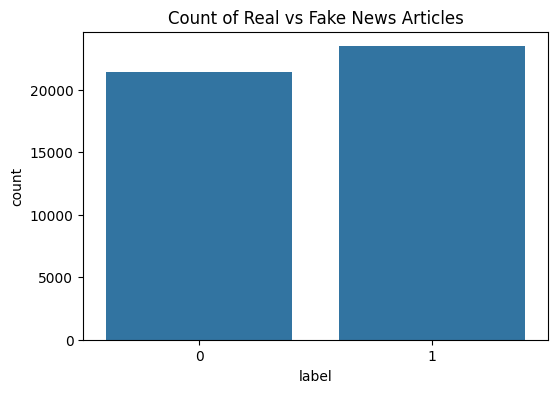

In [73]:
#visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Count of Real vs Fake News Articles')
plt.show()

# Text Preprocessing and Tokenization

In [74]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Define the Cleaning function
# we rely on the TfidVectorizer's built-in 'stop_words' functionality later,
# so we only perform essential cleaning here.

def clean_text(text):
  #convert text to lowercase
  text = text.lower()

  # Remove special characters, numbers, and punctuation (keep only letters and spaces)
  # Replace anything that is NOT a letter or a space with a single space
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)

  # Replace multiple spaces with a single space and trim surrounding whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Filter out single-character word (like 'a' or 'i' if they somehow survived stop word removal)
  words = [word for word in text.split() if len(word) > 1]

  return ' '.join(words)

# Apply the cleaning function to the 'full_text' column
df['cleaned_text'] = df['full_text'].apply(clean_text)

print("--- Text Cleaning Applied ---")
print(f"Original Text Sample: {df['full_text'].iloc[0][:100]}...")
print(f"Cleaned Text Sample: {df['cleaned_text'].iloc[0][:100]}...")




--- Text Cleaning Applied ---
Original Text Sample: RUSSIA Mocks Sore Loser Obama For Trying To Destroy U.S.-Russian Relations Before Trump Takes Office...
Cleaned Text Sample: russia mocks sore loser obama for trying to destroy russian relations before trump takes office vide...


# Data Splitting (Train-Test Split)

In [75]:
import re
from nltk.corpus import stopwords

# Ensure stopwords are available (if not downloaded before)
# This is already done in cell -aqUv-7YQATj, but included here for self-containment if this cell is run independently.
# nltk.download('stopwords') # Uncomment if you encounter NLTK resource errors when running this cell alone
stop_words = set(stopwords.words('english'))

def advanced_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove numbers and punctuation
    words = text.split()
    # Remove stop words (the, is, at) and very short words
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

# Apply advanced cleaning to create the necessary feature columns
df['cleaned_text'] = df['full_text'].apply(advanced_clean)
df['text_for_ml'] = df['full_text'].apply(advanced_clean)  # classical ML features
df['text_for_bert'] = df['full_text']                      # raw text for BERT

# Define feature sets and the target variable
X = df['cleaned_text'] # This is the primary feature set for TF-IDF/PAC
X_ml = df['text_for_ml']
X_bert = df['text_for_bert']
y = df['label']

# The 'label' column was already cleaned for NaNs in cell nHnnc_i8ga0U, so no need for combined_data and dropna here.

# Split the data, ensuring the label distribution is maintained (stratify=y)
# This sets the canonical y_train and y_test for further model evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split for the classical ML feature set, reusing the same y for stratification
# Using _, _ for y_train_ml and y_test_ml to avoid overwriting the base y_train, y_test variables.
X_train_ml, X_test_ml, _, _ = train_test_split(
    X_ml, y, test_size=0.2, random_state=42, stratify=y
)

# Split for the BERT feature set, reusing the same y for stratification
X_train_bert, X_test_bert, _, _ = train_test_split(
    X_bert, y, test_size=0.2, random_state=42, stratify=y
)


print("--- Data Splitting Complete ---")
print(f"Total sample: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}\n")

--- Data Splitting Complete ---
Total sample: 44898
Training samples: 35918
Testing samples: 8980



# Advanced cleaning

In [76]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def advanced_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove numbers and punctuation
    words = text.split()
    # Remove stop words (the, is, at) and very short words
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

df['cleaned_text'] = df['full_text'].apply(advanced_clean)

df['text_for_ml'] = df['full_text'].apply(advanced_clean)  # classical ML
df['text_for_bert'] = df['full_text']                      # raw text


# Feature Engineering (TF-IDF Vectorization)

In [96]:
# 1. Intialize the TF-IDF Vectorizer
# Change your TfidfVectorizer to include pairs of words
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 1), min_df=5, max_features=5000)

In [97]:
# 2. Fit and Transform (CRITICAL step: Fit only on Training Data!)
# .fit() learns the vocabulary from X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [98]:
# 3. Transform (Apply the vocabulary learned from X_train to the test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [80]:
print("--- TF-IDF Vectorization Complete ---")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"Vocabulary size (number of features): {len(tfidf_vectorizer.get_feature_names_out())}")

--- TF-IDF Vectorization Complete ---
X_train_tfidf shape: (35918, 239471)
X_test_tfidf shape: (8980, 239471)
Vocabulary size (number of features): 239471


# Model Development and Training

In [99]:
from sklearn.linear_model import LogisticRegression

# 1. Improved Vectorizer (looks for 1-word and 2-word patterns) specifically for Logistic Regression
tfidf_lr = TfidfVectorizer(max_df=0.7, min_df=5, ngram_range=(1, 1), max_features=5000) # Added max_features here
X_train_tfidf_lr = tfidf_lr.fit_transform(X_train)
X_test_tfidf_lr = tfidf_lr.transform(X_test)

# 2. Use Logistic Regression (often more stable than PAC)
# Reduced C parameter for stronger regularization to combat overfitting
model = LogisticRegression(max_iter=1000, C=0.1)
model.fit(X_train_tfidf_lr, y_train)

# 3. Predict and check
y_pred_lr = model.predict(X_test_tfidf_lr)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)*100:.2f}%")

Logistic Regression Accuracy: 96.90%


# Save the model

In [82]:
import pickle

# 1. Save the trained Logistic Regression Model (assuming this was the intended model as 'model' was trained)
# 'wb' stands for "Write Binary"
with open('fake_news_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# 2. Save the TF-IDF Vectorizer
# This is crucial! Without this, you cannot transform new text for prediction.
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Success! Both the model and vectorizer have been saved as .pkl files.")

Success! Both the model and vectorizer have been saved as .pkl files.


In [83]:
# Check if labels are actually 0 and 1
print(df['label'].value_counts())

label
1    23481
0    21417
Name: count, dtype: int64


In [100]:
pac = PassiveAggressiveClassifier(
    C=0.001,             # Significantly reduced C for stronger regularization
    max_iter=100,      # Give it more time to learn
    validation_fraction=0.1,
    n_iter_no_change=5, # Stop when it stops improving
    random_state=42
)
pac.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(C=0.001, max_iter=100, random_state=42)

In [85]:
!pip install transformers[torch] datasets
from transformers import BertTokenizer, BertForSequenceClassification

# Load the brain of the model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
# Check for empty strings after cleaning
empty_rows = df[df['cleaned_text'] == ''].shape[0]
print(f"Empty text rows: {empty_rows}")

# Check class balance in Training set
print("Training label distribution:")
print(y_train.value_counts(normalize=True))

Empty text rows: 0
Training label distribution:
label
1    0.522997
0    0.477003
Name: proportion, dtype: float64


# Testing and Evaluation

In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure X_test_tfidf has the correct number of features by re-transforming with the original vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 1. Predict (The "Exam" Step)
# We ask the model to guess the labels for the unseen test data
y_pred = pac.predict(X_test_tfidf)

# 2. Calculate Accuracy
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100, 2)}%')

# 3. Create the Confusion Matrix
# This shows: [ [True Positives, False Negatives], [False Positives, True Negatives] ]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 97.95%

Confusion Matrix:
[[4213   71]
 [ 113 4583]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4284
           1       0.98      0.98      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

